In [1]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn geopandas shapely

In [2]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os



file_path = '/content/drive/MyDrive/yelp_academic_dataset_review.json'

# Check if the file exists
print(os.path.exists(file_path))  # Should return True if the file exists

True


In [4]:
##### Code to Filter and Combine the Datasets
#Filter the Review Dataset for Edmonton Restaurants Only: Ensure that only reviews related to restaurants from Edmonton are included.
# Filter Based on Attraction Proximity: Use higher_stars_near_attractions to narrow down reviews to those for restaurants near tourist attractions.

In [5]:
import pandas as pd

# Load the cleaned business dataset
open_restaurants_sorted = pd.read_csv('/content/drive/MyDrive/edmonton_cleaned_business.csv')

# Display the first few rows to confirm
print("Loaded cleaned business dataset:")
display(open_restaurants_sorted.head(3))


Loaded cleaned business dataset:


,business_id,name,latitude,longitude,stars,review_count,is_open,cuisine,nearby_attractions,higher_stars_near_attractions
0,JX4tUpd09YFchLBuI43lGw,Naked Cyber Cafe & Espresso Bar,53.544682,-113.506589,4.0,12,1,other,['Downtown Community Arena'],True
1,5BmQX4UVJY19mMtafMg7JA,Breadland Organic Whole Grain Bakery,53.547205,-113.522448,4.0,23,1,other,"['Oliver Outdoor Swimming Pool', 'Oliver Arena']",True
2,h_qlv6CIXGVurFOhFQ945w,Tim Hortons,53.559979,-113.616269,3.5,6,1,other,[],False


In [6]:
import pandas as pd


# Step 1: Load the review dataset
review_file_path = '/content/drive/MyDrive/yelp_academic_dataset_review.json'
review_df = pd.read_json(review_file_path, lines=True)



In [7]:
# Step 2: Filter the review dataset to include only reviews for Edmonton restaurants in 'open_restaurants_sorted'
edmonton_reviews_df = review_df[review_df['business_id'].isin(open_restaurants_sorted['business_id'])]

# Step 2: Count the number of reviews
num_reviews_edmonton = edmonton_reviews_df.shape[0]

# Step 3: Display the result
print(f"Number of reviews for Edmonton: {num_reviews_edmonton}")

Number of reviews for Edmonton: 58539


In [8]:
# Step 3: Merge 'open_restaurants_sorted' with 'edmonton_reviews_df' to focus on Edmonton restaurants with reviews
merged_df = pd.merge(open_restaurants_sorted, edmonton_reviews_df, on='business_id', how='inner')

# Step 4: Further filter to include only restaurants near tourist attractions with high ratings
# Assuming 'higher_stars_near_attractions' already exists in open_restaurants_sorted
attraction_filtered_review_df = merged_df[merged_df['higher_stars_near_attractions'] == True]
attraction_filtered_review_df.head(3)
attraction_filtered_review_df.shape

(18789, 18)

In [9]:
#Features to Evaluate and Rank
#From the dataset:

#Core Features for Sentiment Analysis:
#text: Essential for sentiment scoring using BERT, VADER, and TextBlob.
#stars_y: Review-specific ratings to validate sentiment scores.
#Additional Features to Evaluate:
#useful, funny, cool: Metrics for review engagement.
#stars_x: Business-level average rating.
#review_count: Popularity indicator for restaurants.
#higher_stars_near_attractions: Location-based feature capturing the impact of proximity to attractions.
#Droppable Features:
#business_id, review_id, user_id: Identifiers; irrelevant for modeling.
#latitude, longitude: Useful only for geospatial clustering.
#nearby_attractions: Can be dropped after creating higher_stars_near_attractions.


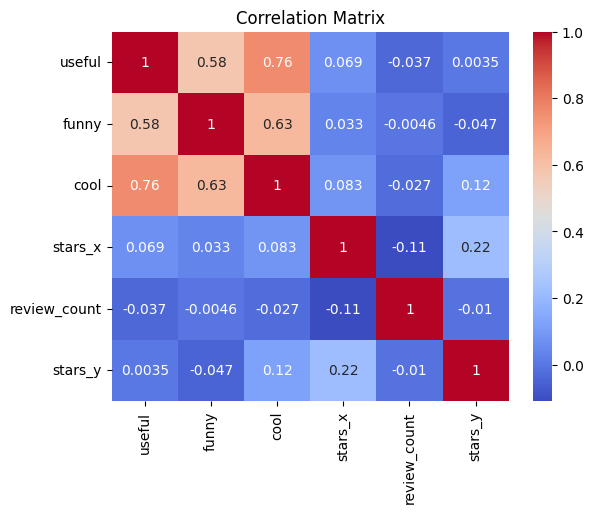

In [10]:
#Step 1: Check Correlations
#Use correlation analysis to determine the relationship between numerical features and stars_y

# Calculate correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = ['useful', 'funny', 'cool', 'stars_x', 'review_count', 'stars_y']
correlation_matrix = attraction_filtered_review_df[numerical_features].corr()

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [11]:
#Interpretation:

#High correlation (>0.3): Feature likely impacts stars_y.
#Low correlation (<0.1): Feature might not add value.

In [12]:
#Step 2: Evaluate Multicollinearity
#Check for multicollinearity using Variance Inflation Factor (VIF).

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # Importing statsmodels


# Prepare data for VIF calculation
X = attraction_filtered_review_df[['useful', 'funny', 'cool', 'stars_x', 'review_count']]
X_with_constant = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X_with_constant.values, i) for i in range(1, X_with_constant.shape[1])]

print("Variance Inflation Factor (VIF):")
vif


Variance Inflation Factor (VIF):


,Feature,VIF
0,useful,2.465670
1,funny,1.714836
2,cool,2.713135
3,stars_x,1.019403
4,review_count,1.013484


In [13]:
#Interpretation:

#VIF > 10: High multicollinearity; consider removing one of the correlated features.
#VIF < 5: Feature is independent and can be kept.

Feature Importance:
        Feature  Importance
4  review_count    0.450220
0        useful    0.176597
1         funny    0.172138
3       stars_x    0.111622
2          cool    0.089423


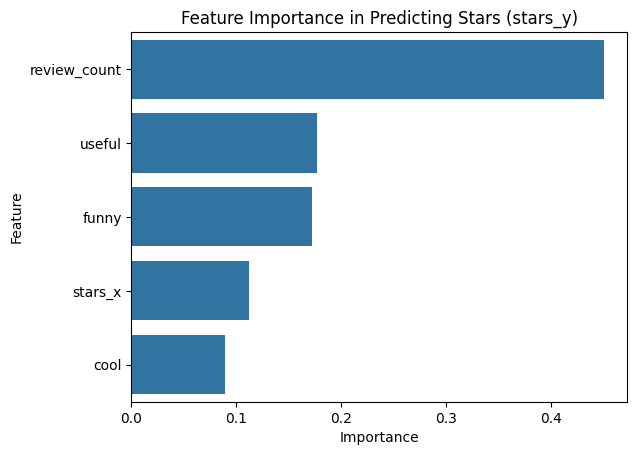

In [14]:
# Next Step: Rank Features Using Random Forest
# Use a Random Forest model to rank these features based on their contribution to predicting stars_y:


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Features and target
features = ['useful', 'funny', 'cool', 'stars_x', 'review_count']
target = 'stars_y'

X = attraction_filtered_review_df[features]
y = attraction_filtered_review_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importances)

# Visualize feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance in Predicting Stars (stars_y)")
plt.show()


In [15]:
#Actions Based on Feature Importance
#Keep Features:

#review_count: Strongly impacts ratings and provides essential context for predicting stars_y.
#useful: Adds value by capturing the usefulness of reviews, moderately influencing ratings.
#funny: Indicates that humor in reviews has a meaningful correlation with stars_y.
#Optional Features:

#stars_x: Business-wide ratings provide context but have less predictive power for individual reviews.
#cool: The least influential feature; consider dropping it unless it's specifically relevant to your analysis.

In [16]:
import pandas as pd

# Define the features to keep based on feature importance and project goals
final_features = [
    'text',               # For sentiment analysis
    'stars_y',            # Review-specific star ratings (target)
    'review_count',       # Business popularity
    'useful',             # User engagement metric
    'funny'               # Humor-related engagement
]

# Create the refined dataset
refined_dataset = attraction_filtered_review_df[final_features]
refined_dataset.describe()
refined_dataset.shape

(18789, 5)

In [17]:
# Save the refined dataset
output_path = '/content/drive/MyDrive/refined_dataset.csv'
refined_dataset.to_csv(output_path, index=False)

In [18]:
# Save the filtered DataFrame to a CSV file
output_path = '/content/drive/MyDrive/attraction_filtered_reviews.csv'
attraction_filtered_review_df.to_csv(output_path, index=False)

print(f"Filtered DataFrame saved successfully to: {output_path}")


Filtered DataFrame saved successfully to: /content/drive/MyDrive/attraction_filtered_reviews.csv
